# [E-06] Text Sentiment Analysis
"Exploration Node 6. Movie Review Text Analysis" / 2022. 01. 27 (Thu) 이형주

## Contents
---
- **1. 데이터 로드 및 전처리**
- **2. 모델 설계, 데이터 분리, 시각화**
- **3. KR word2vec 성능 개선**
- **4. 모델 훈련 및 평가 - LSTM**
- **5. 모델 훈련 및 평가 - GMP** 
- **6. 모델 훈련 및 평가 - CNN** 
- **7. 모델 훈련 및 평가 - LSTM + CNN** 
- **8. 프로젝트 회고** 

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## 1. 데이터 로드 및 전처리

**데이터 로드**

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
# 트레이닝 데이터와 라벨 정보 확인하기
print(train_data.document[0])
print(train_data.label[0])

train_data.info()

# 트레이닝 데이터 (150,000개)
print(len(train_data.document), len(train_data.label))
# 테스트 데이터 (50,000개)
print(len(test_data.document), len(test_data.label))

아 더빙.. 진짜 짜증나네요 목소리
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
150000 150000
50000 50000


**데이터 전처리**

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 중복 데이터 확인
# nunique() : 중복되지 않은 데이터수(146182)
print(train_data['document'].nunique())

# 결측치 
print(train_data.isnull().values.any()) 
# True 
print(test_data.isnull().values.any()) 
# True 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 중복 데이터 정제
    train_data.drop_duplicates(subset=['document'], inplace=True)   
    # inplace=True 는 원본에서 정제
    test_data.drop_duplicates(subset=['document'], inplace=True)   
    # inplace=True 는 원본에서 정제
    
    # NaN 결측치 정제 
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    # 결측치 확인 
    print(train_data.isnull().values.any()) # False 
    print(test_data.isnull().values.any())  # False
    
    # 한국어 Tokenizer
    X_train = []
    for st in train_data['document']:
        temp_x = tokenizer.morphs(st)
        temp_x = [word for word in temp_x if not word in stopwords]   
        # 불용어 제거 
        X_train.append(temp_x)
        
    X_test = []
    for st in test_data['document']:
        temp_x_test = tokenizer.morphs(st)
        temp_x_test = [word for word in temp_x_test if not word in stopwords]   
        # 불용어 제거 
        X_test.append(temp_x_test)
        
    
    # word_to_index
    words = np.concatenate(X_train).tolist()      
    # train data를 list로
    counter = Counter(words)                     
    counter = counter.most_common(10000-4) 
    # pad, bos, unk, unused 제외, 자주 나오는 단어 (10,000 - dictionary)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 -> 인덱스 스트링 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

146182
True
True
id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64
False
False


In [4]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

#index_to_word
index_to_word = {index:word for word, index in word_to_index.items()}

# 문장 1개를 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

146182 49157
146182 49157


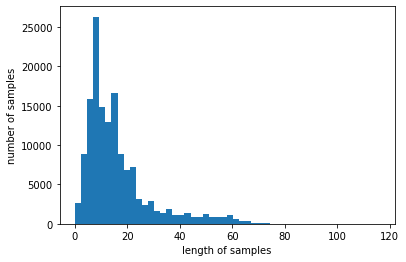

In [5]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# insight
## padding 값이 60 이상부터 매우 커짐
## 문장길이 최대를 50 또는 그 이하로 제한 필요

In [6]:
# 데이터 셋 통합 진행
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

#평균
print('sentence-length-average : ', np.mean(num_tokens))
#최대 -> (average + 2*std.deviation)
print('sentence-length-max : ', np.max(num_tokens))
#표준편차
print('sentence-length-standard-deviation : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('All of {}% include the range of maxlen values '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

sentence-length-average :  15.96940191154864
sentence-length-max :  116
sentence-length-standard-deviation :  12.843571191092
pad_sequences maxlen :  41
All of 0.9342988343341575% include the range of maxlen values 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 2. 모델 설계, 데이터 분리, 결과 시각화

**모델 설계**

In [8]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 (하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  
# 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3616      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

**데이터 분리**

In [9]:
from sklearn import model_selection

x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size = 0.1, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(131563, 41) (131563,)
(14619, 41) (14619,)


**모델 작동**

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=1024
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=2)
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
129/129 - 4s - loss: 0.5164 - accuracy: 0.7370 - val_loss: 0.3680 - val_accuracy: 0.8403
Epoch 2/20
129/129 - 1s - loss: 0.3341 - accuracy: 0.8575 - val_loss: 0.3457 - val_accuracy: 0.8482
Epoch 3/20
129/129 - 1s - loss: 0.2992 - accuracy: 0.8755 - val_loss: 0.3451 - val_accuracy: 0.8495
Epoch 4/20
129/129 - 1s - loss: 0.2726 - accuracy: 0.8887 - val_loss: 0.3444 - val_accuracy: 0.8525
Epoch 5/20
129/129 - 1s - loss: 0.2457 - accuracy: 0.9025 - val_loss: 0.3490 - val_accuracy: 0.8541
Epoch 6/20
129/129 - 1s - loss: 0.2160 - accuracy: 0.9177 - val_loss: 0.3723 - val_accuracy: 0.8490
Epoch 7/20
129/129 - 1s - loss: 0.1864 - accuracy: 0.9312 - val_loss: 0.3923 - val_accuracy: 0.8471
Epoch 8/20
129/129 - 1s - loss: 0.1584 - accuracy: 0.9443 - val_loss: 0.4356 - val_accuracy: 0.8412
Epoch 9/20
129/129 - 1s - loss: 0.1348 - accuracy: 0.9550 - val_loss: 0.4655 - val_accuracy: 0.8396
Epoch 10/20
129/129 - 1s - loss: 0.1151 - accuracy: 0.9635 - val_loss: 0.5068 - val_accuracy: 0.8369

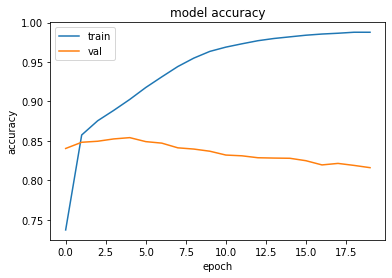

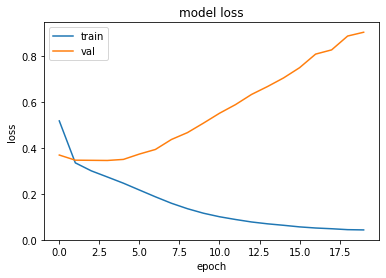

In [11]:
#visualization for history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
#embedding layer
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    

import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

# 단어 개수(에서 특수문자 4개 제외)의 워드 벡터를 파일 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

(10000, 16)


array([-0.0212849 ,  0.01612688,  0.02286533, -0.00324545, -0.01111559,
       -0.00165225, -0.00531986, -0.01427822,  0.00391941,  0.00283402,
       -0.01479512,  0.00353412,  0.00701665, -0.01996804,  0.05366868,
       -0.01125995], dtype=float32)

In [13]:
#word2vec test1
#배우와 연관없는 벡터가 다수 있음 (모델 성능저하)
word_vectors.similar_by_word("배우")

[('규칙', 0.7737053036689758),
 ('몰르', 0.7660144567489624),
 ('걸까', 0.745192289352417),
 ('따로', 0.7410476207733154),
 ('아가씨', 0.7357643246650696),
 ('할배', 0.7334765195846558),
 ('아류', 0.7268668413162231),
 ('장백지', 0.724068284034729),
 ('차인표', 0.710946261882782),
 ('장르노', 0.702974796295166)]

In [14]:
#word2vec test2
#연기와 연관없는 벡터가 다수 있음 (모델 성능저하)
word_vectors.similar_by_word("연기")

[('홍련', 0.8604598045349121),
 ('낸', 0.7939181327819824),
 ('미셸', 0.7810453772544861),
 ('반가운', 0.7769428491592407),
 ('오프닝', 0.7661426067352295),
 ('당당', 0.7522950172424316),
 ('일치', 0.7380517721176147),
 ('켄', 0.7317261695861816),
 ('톰행크스', 0.7256875038146973),
 ('에밀리', 0.7152406573295593)]

## 3. KR word2vec 성능 개선

In [15]:
pip install --upgrade gensim==3.8.3

Note: you may need to restart the kernel to use updated packages.


In [16]:
import gensim
import os
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = Word2Vec.load(word2vec_path)
ko_model.wv.most_similar("배우")

#pretrained word2vec > embedding layer with no word2vec

[('가르치', 0.7075916528701782),
 ('익히', 0.5947338938713074),
 ('공부', 0.5693216919898987),
 ('영화배우', 0.523245096206665),
 ('연출가', 0.509418249130249),
 ('후배', 0.49829238653182983),
 ('연극배우', 0.47326865792274475),
 ('연마', 0.4723285734653473),
 ('선보이', 0.471835732460022),
 ('무용가', 0.46976548433303833)]

In [17]:
ko_model.wv.most_similar("연기")

[('연출', 0.5039602518081665),
 ('뮤직비디오', 0.468474805355072),
 ('주연', 0.45783281326293945),
 ('출연', 0.4573212265968323),
 ('안무', 0.4553908705711365),
 ('캐스팅', 0.43967583775520325),
 ('조연', 0.4288240671157837),
 ('단역', 0.4258745610713959),
 ('영화화', 0.4199691116809845),
 ('냄새', 0.4133602976799011)]

In [18]:
#changing embedding layer
#hyperparameters 166,513 -> 2,027,121

vocab_size = 10000   
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 하나씩 복사
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]
        
from tensorflow.keras.initializers import Constant

# 모델
model_conv = keras.Sequential()
model_conv.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_conv.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_conv.add(keras.layers.MaxPooling1D(5))
model_conv.add(keras.layers.Conv1D(32, 7, activation='relu'))
model_conv.add(keras.layers.GlobalMaxPooling1D())
model_conv.add(keras.layers.Dense(32, activation='relu'))
model_conv.add(keras.layers.Dense(1, activation='sigmoid')) 

model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             3616      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

/tmp/ipykernel_655/4214867982.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
/tmp/ipykernel_655/4214867982.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


In [19]:
#모델 작동
model_conv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=1024

history = model_conv.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
129/129 [==============================] - 3s 14ms/step - loss: 0.5571 - accuracy: 0.7019 - val_loss: 0.4596 - val_accuracy: 0.7839
Epoch 2/20
129/129 [==============================] - 1s 9ms/step - loss: 0.4097 - accuracy: 0.8147 - val_loss: 0.3965 - val_accuracy: 0.8206
Epoch 3/20
129/129 [==============================] - 1s 9ms/step - loss: 0.3479 - accuracy: 0.8487 - val_loss: 0.3690 - val_accuracy: 0.8375
Epoch 4/20
129/129 [==============================] - 1s 9ms/step - loss: 0.3101 - accuracy: 0.8694 - val_loss: 0.3547 - val_accuracy: 0.8451
Epoch 5/20
129/129 [==============================] - 1s 9ms/step - loss: 0.2855 - accuracy: 0.8821 - val_loss: 0.3556 - val_accuracy: 0.8475
Epoch 6/20
129/129 [==============================] - 1s 9ms/step - loss: 0.2621 - accuracy: 0.8933 - val_loss: 0.3502 - val_accuracy: 0.8517
Epoch 7/20
129/129 [==============================] - 1s 9ms/step - loss: 0.2418 - accuracy: 0.9044 - val_loss: 0.3800 - val_accuracy: 0.8420
Epoch

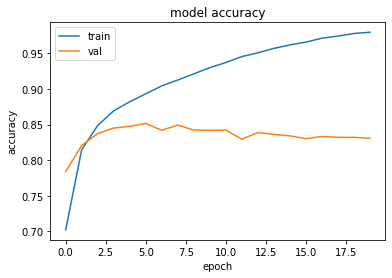

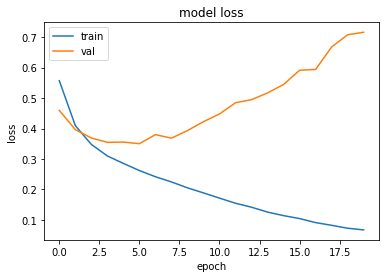

1537/1537 - 2s - loss: 0.9179 - accuracy: 0.8133
[0.9179069399833679, 0.8132920861244202]


In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

#embedding layer 교체 후 Accuracy 소폭 증가

## 4. 모델 훈련 및 평가 - LSTM

In [23]:
# LSTM - 모델 훈련 및 평가

##설계
vocab_size = 10000
word_vector_dim = 200  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model_LSTM.add(keras.layers.LSTM(512))   
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

## 모델 작동
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=1024

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1460224   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 3,460,737
Trainable params: 3,460,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
129/129 [==============================] - 17s 118ms/step - loss: 0.4828 - accuracy: 0.7610 - val_loss: 0.3760 - val_accuracy: 0.8333
Epoch 2/10
129/129 [==============================] - 15s 116ms/step - loss: 0.3343 - accuracy: 0.8537 - val_loss: 0.3225 - val_accuracy: 0.8606
Epoch 3/10
129/129 [==============================] - 15s 116ms/step - loss: 0.2842 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f1d4ada19d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


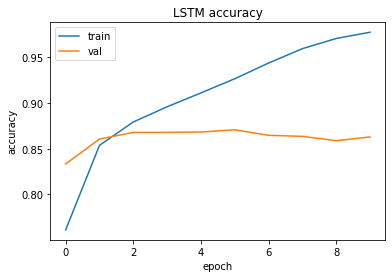

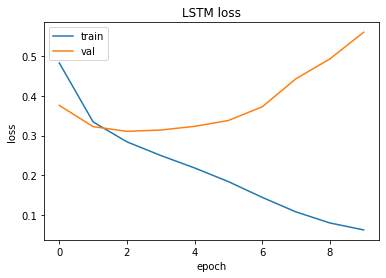

1537/1537 - 5s - loss: 0.5752 - accuracy: 0.8578
[0.5751919150352478, 0.8577821850776672]


In [25]:
# accuracy
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

## 5. 모델 훈련 및 평가 - GMP

In [27]:
# GlobalMaxPooling1D - 모델 훈련 및 평가

## 모델 설계
vocab_size = 10000
word_vector_dim = 200  

model_GMP = keras.Sequential()
model_GMP.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True)) 
model_GMP.add(keras.layers.GlobalMaxPooling1D())
model_GMP.add(keras.layers.Dense(7, activation='relu'))
model_GMP.add(keras.layers.Dense(1, activation='sigmoid'))  
model_GMP.summary()

## 모델 작동
model_GMP.compile(optimizer=keras.optimizers.Adam(0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=1024

history_GMP = model_GMP.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model_GMP.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 1407      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 8         
Total params: 2,001,415
Trainable params: 2,001,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
129/129 [==============================] - 1s 7ms/step - loss: 0.7239 - accuracy: 0.5502 - val_loss: 0.6652 - val_accuracy: 0.6435
Epoch 2/10
129/129 [==============================] - 1s 5ms/step - loss: 0.5956 - accuracy: 0.7188 

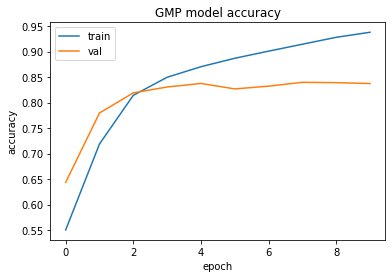

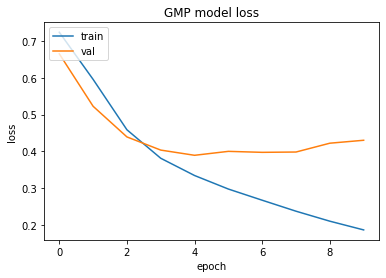

In [28]:
# accuracy
plt.plot(history_GMP.history['accuracy'])
plt.plot(history_GMP.history['val_accuracy'])
plt.title('GMP model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss
plt.plot(history_GMP.history['loss'])
plt.plot(history_GMP.history['val_loss'])
plt.title('GMP model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 6. 모델 훈련 및 평가 - CNN

In [30]:
# CNN - 모델 훈련 및 평가

vocab_size = 10000
word_vector_dim = 200

## 모델 설계
model_conv_tuned = keras.Sequential()
model_conv_tuned.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_conv_tuned.add(keras.layers.Conv1D(64, 10, activation='relu'))
model_conv_tuned.add(keras.layers.GlobalMaxPooling1D())
model_conv_tuned.add(keras.layers.Dense(1, activation='sigmoid')) 

model_conv_tuned.summary()

## 모델 작동
model_conv_tuned.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=1024

history_conv = model_conv_tuned.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model_conv_tuned.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 32, 64)            128064    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 2,128,129
Trainable params: 2,128,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
129/129 [==============================] - 2s 14ms/step - loss: 0.6142 - accuracy: 0.7003 - val_loss: 0.4862 - val_accuracy: 0.7698
Epoch 2/10
129/129 [==============================] - 2s 12ms/step - loss: 0.4193 - accuracy: 0.808

**Accuricies by Models**

+ CNN: **0.8366661667823792**
+ GMP: 0.8340826034545898
+ LSTM: **0.8577821850776672**

## 7. 모델 훈련 및 평가 - LSTM + CNN

In [35]:
vocab_size = 10000
word_vector_dim = 200  

# 모델 설계
model_CNN_LSTM = keras.Sequential()
model_CNN_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True)) 
model_CNN_LSTM.add(keras.layers.Conv1D(3, 7, activation='relu'))
model_CNN_LSTM.add(keras.layers.LSTM(128))   
model_CNN_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))
model_CNN_LSTM.summary()

# 모델 작동
model_CNN_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=512

history_CNN_LSTM = model_CNN_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model_CNN_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 3)             4203      
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 2,071,916
Trainable params: 2,071,916
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
257/257 [==============================] - 4s 12ms/step - loss: 0.5087 - accuracy: 0.7416 - val_loss: 0.4070 - val_accuracy: 0.8175
Epoch 2/10
257/257 [==============================] - 3s 10ms/step - loss: 0.3705 - accuracy: 0.83

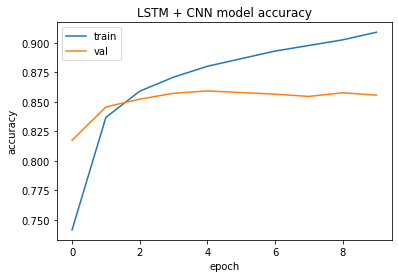

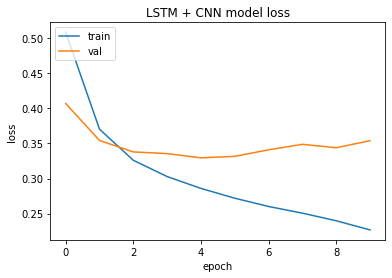

In [37]:
# accuracy
plt.plot(history_CNN_LSTM.history['accuracy'])
plt.plot(history_CNN_LSTM.history['val_accuracy'])
plt.title('LSTM + CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss
plt.plot(history_CNN_LSTM.history['loss'])
plt.plot(history_CNN_LSTM.history['val_loss'])
plt.title('LSTM + CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### LSTM + CNN Model Accuracy: 85.03%

## 8. 프로젝트 회고

+ Model Accuracy를 높이기 위하여 많이 노력했다.
    - 데이터의 최대 길이는 평균 + (2*표준편차)로 계산함: Source https://infuture.kr/626
    - 시각화된 결과를 바탕으로 파라미터를 조정하였음
    - LSTM + CNN 모델로 Accuracy 목표치를 달성하였음


+ 각 단어 (배우, 연기)의 유사어를 출력하도록 하여 Embedding Layer의 성능을 확인했다.
    - Embedding Layer 교체 이후 Accuracy 상승의 효과를 거두었음


+ 감정분석은 추후 취업을 할 때에 가장 많이 활용할 것으로 (업무 자동화) 기대되는 태스크여서 관심있게 진행하였다.
+ 토큰화, 벡터화 과정에서 문장과 단어의 관련성을 잘 파악하고 정제가 잘 이루어질 수 있도록 더 학습을 진행하고자 한다.